# Anchor Vector Optimization

In [241]:
import gensim
import numpy as np
import scipy
import tensorflow as tf

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [10]:
# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format('./word2vec/GoogleNews-vectors-negative300.bin', binary=True)

In [30]:
anchor_words = ['travel', 'hotel', 'resort', 'airfare', 'cruise', 'plane', 'vacation', 'train', 'inn', 'Hilton']
anchor_vecs = [model.get_vector(w) for w in anchor_words]

travel_words = ['hilton', 'inns', 'suites', 'Marriott', 'courtyard', 'Hilton', 'Westin', 'Comfort_Suites', 'Double_Tree']
bad_words = ['potato', 'target', 'walmart', 'walk', 'industrial', 'mechanical', 'fresh', 'phone', 'discover', 
             'pinata', 'save', 'nooshi', 'capitol', 'smash', 'burger', 'chase']

hilton = model.get_vector('hilton')
hilton_dist = model.distance('hilton', 'pinata')
hilton_dist

0.8759593252252431

In [17]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

anchors = [
    np.array([0.10, 0.20]),
    np.array([0.33, 0.81]),
    np.array([0.67, 0.52]),
    np.array([0.60, 0.84])
]

dist = lambda a, b: np.linalg.norm(a - b)

def f(x, y, anchors, p=2, q=1):
    
    result = 1
    for a in anchors:
        norm = ((x - a[0])**p + (y - a[1])**p)**(1/p)
        result *= norm
    
    result ** 2
    
    return (1 - result)**q

def sigmoid(x, w = 1, b = 0):
    
    s = 1 / (1 + np.exp(-x * w + b))
    return s

Text(0.5,0,'z')

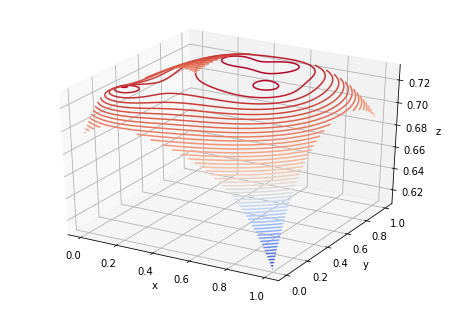

In [26]:
%matplotlib inline

Z = f(X, Y, anchors, q=1)
Z = sigmoid(Z, 1, 0)

fig = plt.figure()
ax = Axes3D(fig)
ax.contour3D(X, Y, Z, 50, cmap = 'coolwarm')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

<IPython.core.display.Javascript object>


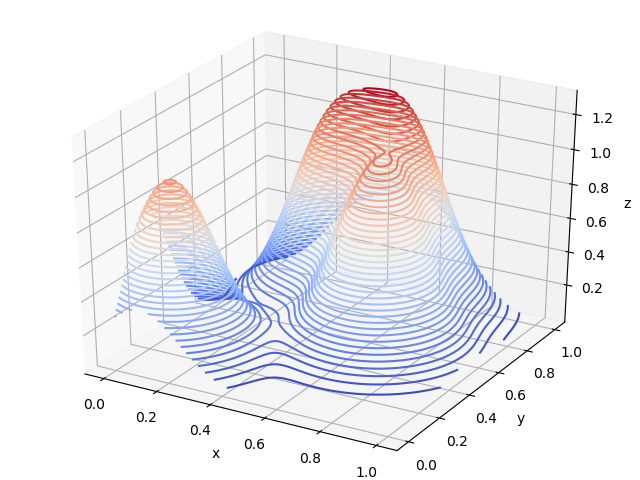

Text(0.5,0,'z')

In [9]:
def gauss_kernel(x, y, anchors, c = 1):
    result = 0
    for a in anchors:
        result += np.exp((-((x - a[0])/c)**2 - ((y - a[1])/c)**2))
    return result

%matplotlib notebook

Z_gauss = gauss_kernel(X, Y, anchors, c = 0.2)

fig = plt.figure()
ax = Axes3D(fig)
ax.contour3D(X, Y, Z_gauss, 50, cmap = 'coolwarm')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

In [560]:
cart_to_sphere(*sphere_to_cart(1, np.pi/2, 3/2*np.pi))

(1.0, 1.5707963267948966, -1.5707963267948968)

In [ ]:
def get_norm(A, data):
    
    A_norm = np.atleast_2d(np.linalg.norm(A, axis = 0)).T
    data_norm = np.atleast_2d(np.linalg.norm(data, axis = 0))
    norm = np.dot(A_norm, data_norm)
    
    return norm

def get_cos_dist(A, data):
    
    norm = get_norm(A, data)
    sim = np.dot(A.T, data)/norm
    dist = 1 - sim
    
    return dist

# Multiplicative Distance
get_D = lambda dist: np.prod(dist, axis = 0)
    
# Sigmoid
sigmoid = lambda x: 1/(1 + np.exp(-x))

# --------------------------- #

# Choose 4 random points from training set to initialize anchors
indices = np.array([i for i in range(len(X))])
np.random.shuffle(indices)
ix_rand = indices[:4]

# Initialize parameters
A_0 = np.array([X[ix_rand], Y[ix_rand], Z[ix_rand]])
w_0 = 0
b_0 = 0

A = A_0 # shape = (3, 4)
w = w_0
b = b_0
data = np.array([X, Y, Z]) # shape = (3, 200)

D = get_D(get_cos_dist(A, data))
prob = sigmoid(D * w + b)

# Generate Data

In [127]:
x_data = np.random.randn(500)
y_data = np.random.randn(500)
z_data = np.random.randn()

def sphere_to_cart(r, theta, phi):

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi) 
    z = r * np.cos(theta) 
    
    return x, y, z

def cart_to_sphere(x, y, z):
    
    r = (x**2 + y**2 + z**2)**0.5
    theta = np.arccos(z/r)
    phi = np.arctan2(y, x)
    
    return r, theta, phi

def rand_points(num = 50, mu = 0, sigma = 1):
    
    return np.random.randn(num) * sigma - mu

def rand_points_unif(num = 50, mu = [0, 0, 0], sigma = 0.2):
    
    x_1 = np.random.randn(num) * sigma - mu[0]
    x_2 = np.random.randn(num) * sigma - mu[1]
    x_3 = np.random.randn(num) * sigma - mu[2]
    
    return x_1, x_2, x_3

x = {}
y = {}
z = {}

x[1] = rand_points(mu = 1.2, sigma = 0.3)
y[1] = rand_points(mu = 1.4, sigma = 0.4)
z[1] = rand_points(mu = 0.9, sigma = 0.2)

x[2] = rand_points(mu = 1.5, sigma = 0.3)
y[2] = rand_points(mu = 0.2, sigma = 0.2)
z[2] = rand_points(mu = -0.7, sigma = 0.3)

x[3] = rand_points(mu = 0.6, sigma = 0.2)
y[3] = rand_points(mu = 1.3, sigma = 0.2)
z[3] = rand_points(mu = 0.8, sigma = 0.6)

x[4] = rand_points(mu = -0.2, sigma = 0.3)
y[4] = rand_points(mu = -0.6, sigma = 0.2)
z[4] = rand_points(mu = 1.2, sigma = 0.5)

X_pos = np.concatenate([x[1], x[2], x[3], x[4]])
Y_pos = np.concatenate([y[1], y[2], y[3], y[4]])
Z_pos = np.concatenate([z[1], z[2], z[3], z[4]])

x[5], y[5], z[5] = sphere_to_cart(*rand_points_unif(mu = [1, -1, 1], sigma = 0.2))
x[6], y[6], z[6] = sphere_to_cart(*rand_points_unif(mu = [1, 2, 2], sigma = 0.4))
x[7], y[7], z[7] = sphere_to_cart(*rand_points_unif(mu = [1, 2.7, -2], sigma = 0.5))
x[8], y[8], z[8] = sphere_to_cart(*rand_points_unif(mu = [1, 2, 0.5], sigma = 0.5))

X_neg = np.concatenate([x[5], x[6], x[7], x[8]])
Y_neg = np.concatenate([y[5], y[6], y[7], y[8]])
Z_neg = np.concatenate([z[5], z[6], z[7], z[8]])

r_pos, theta_pos, phi_pos = cart_to_sphere(X_pos, Y_pos, Z_pos)
r_neg, theta_neg, phi_neg = cart_to_sphere(X_neg, Y_neg, Z_neg)

data_pos = np.array([X_pos, Y_pos, Z_pos])
data_neg = np.array([X_neg, Y_neg, Z_neg])
labels_pos = np.ones((1, data_pos.shape[1]))
labels_neg = np.zeros((1, data_pos.shape[1]))

data = np.concatenate([data_pos, data_neg], axis = 1)
labels = np.concatenate([labels_pos, labels_neg], axis = 1)

m = data.shape[1]
indices = np.array([i for i in range(m)])
np.random.shuffle(indices)

m_train = int(0.8 * m)
m_test = m - m_train

ix_train = indices[:m_train]
ix_test = indices[m_train:]

X_train = data[:, ix_train]
X_test = data[:, ix_test]

Y_train = labels[:, ix_train]
Y_test = labels[:, ix_test]

# Visualize Data

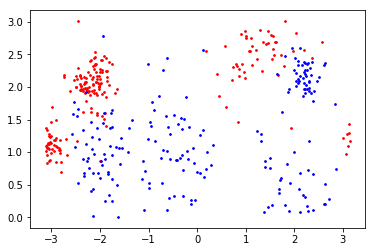

In [128]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# ax = Axes3D(fig)
# ax.scatter(X, Y, Z)
ax.scatter(phi_pos, theta_pos, c = 'red', s = 3)
ax.scatter(phi_neg, theta_neg, c = 'blue', s = 3)

# Set up Model

In [277]:
def create_placeholders(n_x, n_y):
    
    X = tf.placeholder(tf.float32, shape = [n_x, None], name = "X")
    Y = tf.placeholder(tf.float32, shape = [n_y, None], name = "Y")
    
    return X, Y

def initialize_params(k, n_x):
    
    # k anchors
    # n features
    
    A = tf.get_variable("A", [k, n_x], dtype = tf.float32, initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    w = tf.get_variable("w", [1], dtype = tf.float32, initializer = tf.zeros_initializer())
    b = tf.get_variable("b", [1], dtype = tf.float32, initializer = tf.zeros_initializer())
    
    params = {
        "A": A,
        "w": w,
        "b": b
    }
                        
    return params

def forward_propagate(X, params):

    # X.shape = (n, m)
    # A.shape = (k, n)
    
    A = params["A"]
    w = params["w"]
    b = params["b"]
    
    Z = tf.matmul(A, X)
    norm_A0 = tf.norm(A, axis = 1)
    norm_A1 = tf.reshape(norm_A0, (tf.shape(norm_A0)[0], 1))
    norm_X0 = tf.norm(X, axis = 0)
    norm_X1 = tf.reshape(norm_X0, (1, tf.shape(norm_X0)[0]))
    norm = tf.matmul(norm_A1, norm_X1)
    sim = tf.divide(Z, norm) # shape = (k, m)
    dist = 1 - sim
    D = tf.reduce_prod(dist, axis = 0) # shape = (1, m)
    H = tf.sigmoid(w * D + b)
    
    return H

def get_cost(Y, H):
    
    # Y.shape = (1, m)
    # D.shape = (1, m)
    
    m = tf.cast(tf.shape(Y)[1], dtype = "float32")
    cost = - 1 / m * tf.reduce_sum((Y * tf.log(H) + (1 - Y) * tf.log(1 - H)))
    
    return cost



def random_mini_batches(X_train, Y_train, minibatch_size, seed):
    
    np.random.seed(seed)
    (n, m) = X_train.shape
    indices = np.array([i for i in range(n)])
    np.random.shuffle(indices)
    
    minibatches = []
    i = 0
    
    while i < m:
        
        minibatches.append((X_train[:, i:i+minibatch_size], Y_train[:, i:i+minibatch_size]))
        i += minibatch_size
    
    return minibatches

def model(X_train, 
          Y_train, 
          X_test, 
          Y_test, 
          k = 4,
          learning_rate = 0.0001,
          num_epochs = 1500, 
          minibatch_size = 32, 
          print_cost = True):
    
    # X_train.shape = (n_x, m)
    # Y_train.shape = (1, m)
    
    tf.reset_default_graph()
    
    tf.set_random_seed(1)
    seed = 2
    
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    costs = []
    
    X, Y = create_placeholders(n_x, n_y)
    params = initialize_params(k, n_x)
    H = forward_propagate(X, params)
    cost = get_cost(Y, H)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):

            epoch_cost = 0
            num_minibatches = int(m / minibatch_size)
            seed += 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / num_minibatches
            
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        params = sess.run(params)
        print("Training complete.")
        
        pred = sess.run(H, feed_dict = {X: X_test})
        
        return pred, params

# Run Model

Cost after epoch 0: 0.693081
Cost after epoch 100: 0.658618
Cost after epoch 200: 0.601788
Cost after epoch 300: 0.558373
Cost after epoch 400: 0.530771
Cost after epoch 500: 0.512027
Cost after epoch 600: 0.498640
Cost after epoch 700: 0.488668
Cost after epoch 800: 0.481071
Cost after epoch 900: 0.475195
Cost after epoch 1000: 0.470598
Cost after epoch 1100: 0.466974
Cost after epoch 1200: 0.464096
Cost after epoch 1300: 0.461784
Cost after epoch 1400: 0.459888
Cost after epoch 1500: 0.458288
Cost after epoch 1600: 0.456887
Cost after epoch 1700: 0.455614
Cost after epoch 1800: 0.454416
Cost after epoch 1900: 0.453257
Cost after epoch 2000: 0.452110
Cost after epoch 2100: 0.450958
Cost after epoch 2200: 0.449788
Cost after epoch 2300: 0.448588
Cost after epoch 2400: 0.447348
Cost after epoch 2500: 0.446054
Cost after epoch 2600: 0.444687
Cost after epoch 2700: 0.443223
Cost after epoch 2800: 0.441629
Cost after epoch 2900: 0.439862
Cost after epoch 3000: 0.437864
Cost after epoch 310

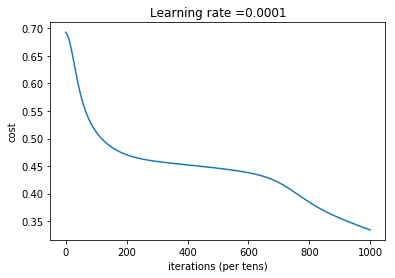

Training complete.


In [286]:
pred, params = model(X_train, Y_train, X_test, Y_test, k = 4, num_epochs = 5000)

In [287]:
params

{'A': array([[-0.29652452, -0.87305176, -0.8913188 ],
        [-0.34752998, -0.01504137,  0.1889065 ],
        [ 0.57741255,  0.41741344, -0.19353569],
        [ 0.13701116, -0.14719032, -0.38311696]], dtype=float32),
 'b': array([1.3441963], dtype=float32),
 'w': array([-3.3542738], dtype=float32)}

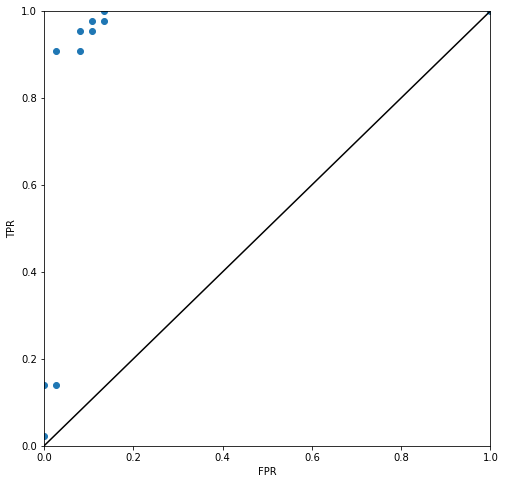

In [288]:
fpr, tpr, thresh = roc_curve(Y_test.flatten().tolist(), pred.flatten().tolist())

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot([0, 1], [0, 1], 'k')
plt.scatter(fpr, tpr)

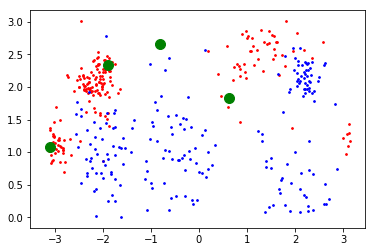

In [290]:
%matplotlib inline

A_learned = params["A"]

A_r, A_theta, A_phi = cart_to_sphere(A_learned[:, 0], A_learned[:, 1], A_learned[:, 2])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(phi_pos, theta_pos, c = 'red', s = 3)
ax.scatter(phi_neg, theta_neg, c = 'blue', s = 3)
ax.scatter(A_phi, A_theta, c = 'green', s = 100)

Text(0.5,0,'z')

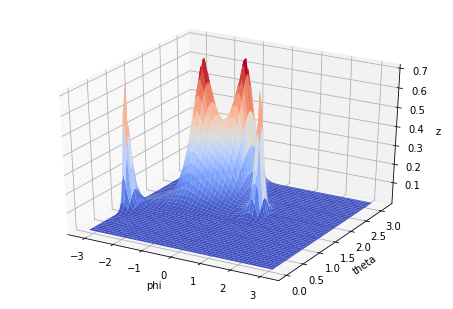

In [292]:
%matplotlib inline
phi = np.linspace(-np.pi, np.pi, 100)
theta = np.linspace(0, np.pi, 100)
Phi, Theta = np.meshgrid(phi, theta)

anchors = [np.array(k) for k in np.array([A_phi, A_theta]).T.tolist()]

# HOW TO PLOT MULTIPLICATIVE *COS* DISTANCE FUNCTION? (Right now, it's plotting Euclidean, so it's wrong.)

Z = f(Phi, Theta, anchors, q=1)
Z = sigmoid(Z, 1, 0)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(Phi, Theta, Z, cmap = 'coolwarm')
ax.set_xlabel("phi")
ax.set_ylabel("theta")
ax.set_zlabel("z")

In [221]:
np.array([A_phi, A_theta]).T.tolist()

[[-1.3955433368682861, 2.3328168392181396],
 [2.8350436687469482, 1.0185434818267822],
 [-0.05454245209693909, 2.1315441131591797],
 [0.12568172812461853, 2.0323338508605957],
 [0.5207718014717102, 1.7050480842590332],
 [0.3207947909832001, 1.8760560750961304],
 [-2.288407802581787, 1.9950625896453857],
 [-3.041581630706787, 1.0597203969955444],
 [-0.1351875513792038, 2.175006866455078],
 [-0.18539245426654816, 2.1952128410339355]]

# Debug

In [180]:
n_x = X_train.shape[0]
n_y = Y_train.shape[0]
k = 4

tf.reset_default_graph()

def get_cost(Y, H):
    m = tf.cast(tf.shape(Y)[1], dtype = "float32")
    cost = - 1 / m * tf.reduce_sum((Y * tf.log(H) + (1 - Y) * tf.log(1 - H)))
    return cost

X, Y = create_placeholders(n_x, n_y)
params = initialize_params(k, n_x)
H = forward_propagate(X, params)
cost = get_cost(Y, H)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    
    sess.run(init)
    
    p_results = sess.run(cost, feed_dict = {X: X_train, Y: Y_train})
    
p_results

0.6931468